# Load HDF5 file

In [1]:
import h5py

data_path = r'C:\Users\k.t.vangeijtenbeek\Documents\Data\ECGs_hdf5_1pp\ecgs.hdf5'
data = h5py.File(data_path, 'r')['data']

print(data)

<HDF5 dataset "data": shape (1143, 5000, 12), type "<f4">


In [17]:
import math
import numpy as np
from tqdm import tqdm

def preprocess_data(data_x, smooth_window_size=51, smooth_order=4, fourier_baseline_resolution=20, verbosity=False):
    """ function: preprocess_data
    preprocess the data by smoothing and straightening.
    Args:
        data_x : np.ndarray
            the data to preprocess.
    Returns:
        p_data_x : np.ndarray
            preprocessed data
    """
    assert data_x.ndim == 3

    if verbosity:
        print("Preprocessing data...")
        start = time.time()

    p_data_x = np.empty(shape=data_x.shape)

    for i, ecg in tqdm(enumerate(data_x)):
        for channel in range(ecg.shape[1]):
            prepped_channel = savitzky_golay(
                ecg[:, channel],
                window_size = smooth_window_size,
                order = smooth_order
            )
            prepped_channel = fourier_straighten(
                prepped_channel,
                resolution = fourier_baseline_resolution
            )
            p_data_x[i, :, channel] = prepped_channel
        
            
    if verbosity:
        print('\nDone, took ' + str(round(time.time() - start, 1)) + ' seconds')
    return p_data_x

def savitzky_golay(y, window_size=51, order=4, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    Note: this code was copied from:
    https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
    """
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * math.factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def fourier_straighten(signal, resolution=20):
    """ function: fourier_straighten
    straighten an ecg using a low resolution to obtain ecg baseline, and then
    straightening the ecg by setting the baseline to zero
    Args:
        signal : np.ndarray
            the ecg signal to straighten
        resolution : int [optional, default: 20]
            the resolution of the baseline. if set to high important details
            from the ecg will be removed, recommended to keep under 30
    Returns:
        corrected_ecg : np.ndarray
            the straightened array
    """
    assert signal.ndim == 1
    c = get_fourier_coefficients(signal, resolution)
    baseline = reconstruct_wave(coefficients=c, signal_length=signal.shape[0])

    corrected_ecg = np.subtract(signal, baseline)
    return corrected_ecg

def get_fourier_coefficients(signal, resolution=600):
    """ function: get_fourier_coefficients
    perform fourier series analysis on a signal and return the nth coefficient
    for a function that approximate the wave
    assumes the data is modelled by an even function (f(x) = f(-x)).
    the function on this page is followed (the second one under cosine series)
    https://en.wikipedia.org/wiki/Fourier_sine_and_cosine_series.
    the function that reconstructs this wave is: reconstruct_wave
    Args:
        signal : np.ndarray
            a 1d array containing the signal to perform the analysis on
        resolution : int [optional, default: 600]
            the amount of coefficients to return. the higher the resolution the
            higher the fidelity of the reconstructed wave
    Returns:
        coefficients : np.ndarray
            a 1d array containing the coefficients that model the given data
    """
    # only works if array is 1d
    assert signal.ndim == 1
    linspace = np.linspace(0, 1, len(signal)).reshape((-1, 1))
    pi_n = np.pi * np.arange(resolution).reshape((1, -1))
    tmp1 = np.cos(linspace @ pi_n)
    tmp2 = signal.reshape((-1,1)) * tmp1
    coefficients = (2/len(signal)) * np.sum(tmp2, axis=0)
    return coefficients

def reconstruct_wave(coefficients, signal_length):
    """ function: reconstruct wave
    reconstructs a wave using a given set of coefficients using the function as
    seen on this page (first equation under cosine series)
    https://en.wikipedia.org/wiki/Fourier_sine_and_cosine_series
    Args:
        coefficients : np.ndarray
            a 1d array of coefficients to reconstruct wave from, such as those
            given by the function get_fourier_coefficients
        signal_length : int
            the target length of the reconstructed array
    Returns:
        reconstruction : np.ndarray
            a 1d array of length signal_length that approximates the data of
            which the coefficients were extracted
    """
    x = np.arange(signal_length).reshape((-1,1))
    n = np.arange(len(coefficients)).reshape((1,-1))
    tmp1 = np.cos(((x @ n) * np.pi) / signal_length)
    coefficients[0]  = coefficients[0] / 2
    tmp2 = tmp1 * coefficients
    reconstruction = np.sum(tmp2, axis=1)
    return reconstruction

In [18]:
import sys
import os

module_paths = []
module_paths.append(os.path.abspath(os.path.join(r'C:\Users\k.t.vangeijtenbeek\Documents\Code')))
module_paths.append(os.path.abspath(os.path.join(r'C:\Users\k.t.vangeijtenbeek\Documents\Code\data_processing')))

for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)

from data_processing.ecgplotter import plot_ecg

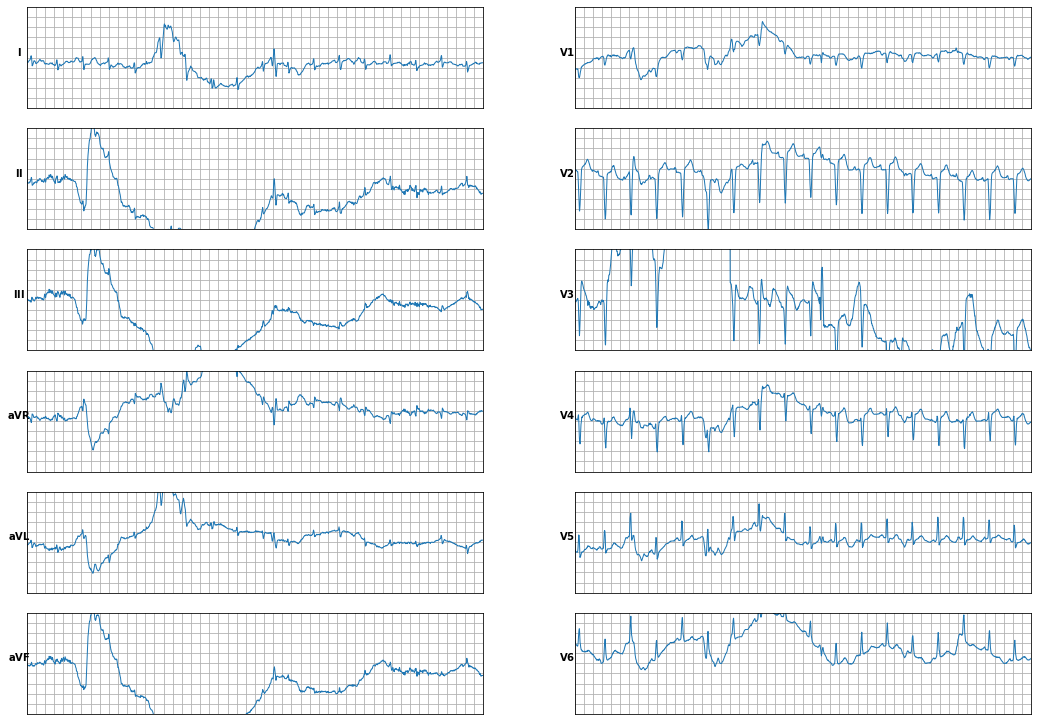

In [26]:
# idx = 1011
# idx = 1193
# idx = 2011
idx = 2020

data_path = r'C:\Users\k.t.vangeijtenbeek\Documents\Data\ECGs_hdf5\ecgs.hdf5'
data = h5py.File(data_path, 'r')['data']

_ = plot_ecg(data[idx])

1it [00:00, 20.83it/s]


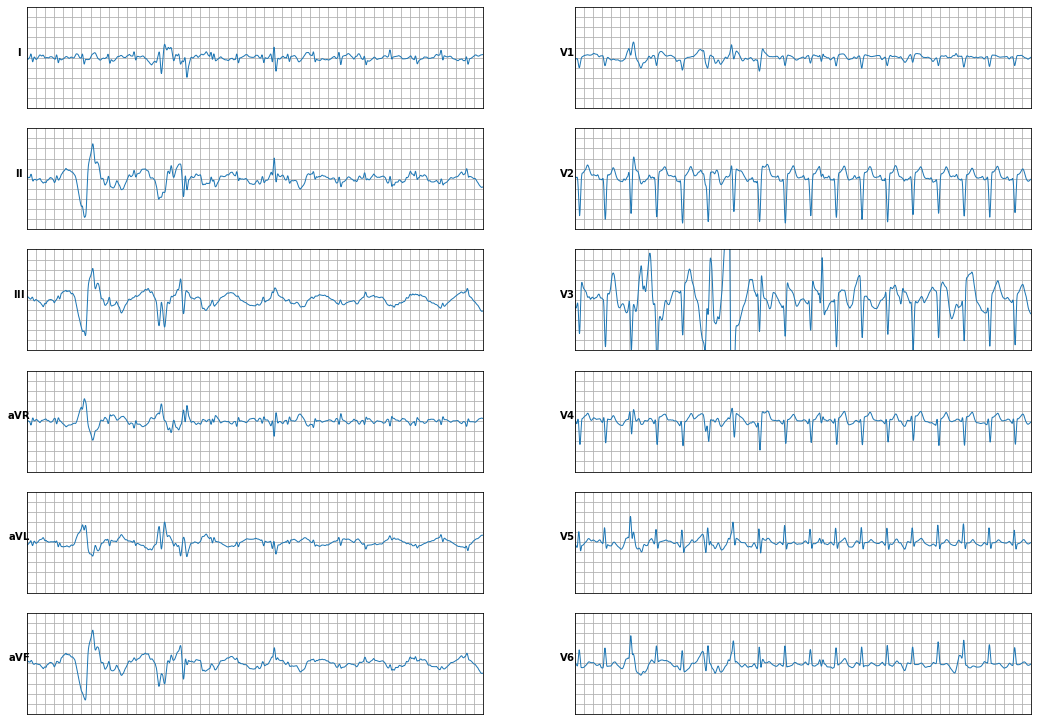

In [27]:
p_ecg = preprocess_data(data[idx:idx+1])
_ = plot_ecg(p_ecg[0])

In [11]:
new_path = r'C:\Users\k.t.vangeijtenbeek\Documents\Data\ECGs_hdf5_1pp\ecgs_nobw.hdf5'
with h5py.File(new_path, 'a') as f:
    # Store ecg data
    dset_data = f.create_dataset('data', data.shape, dtype='f4')
    batch_size = 100
    for i in range(0, len(data), batch_size):
        print(f'{i}/{len(data)}')
        p_data = preprocess_data(data[i:i+batch_size])
        dset_data[i:i+batch_size] = p_data

3it [00:00, 20.83it/s]

0/1143


100it [00:04, 20.99it/s]
3it [00:00, 20.69it/s]

100/1143


100it [00:04, 20.83it/s]
3it [00:00, 21.28it/s]

200/1143


100it [00:04, 21.15it/s]


300/1143


100it [00:04, 20.91it/s]
3it [00:00, 20.74it/s]

400/1143


100it [00:04, 21.26it/s]
3it [00:00, 21.32it/s]

500/1143


100it [00:04, 20.09it/s]
2it [00:00, 17.06it/s]

600/1143


100it [00:04, 20.58it/s]
2it [00:00, 18.91it/s]

700/1143


100it [00:04, 20.81it/s]
2it [00:00, 18.01it/s]

800/1143


100it [00:04, 20.47it/s]
2it [00:00, 17.67it/s]

900/1143


100it [00:04, 20.17it/s]
3it [00:00, 21.33it/s]

1000/1143


100it [00:04, 20.82it/s]
3it [00:00, 22.17it/s]

1100/1143


43it [00:02, 21.22it/s]
